In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import numpy as np
from tensorflow.keras.models import Model

from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input

In [2]:
pixels = 224

# Input pixel dimensions.  All training and test examples will be resized to (pixel, pixel, 3)
conv_base = NASNetMobile(weights='imagenet', include_top=False, input_shape=(pixels,pixels,3))

conv_base.trainable = False


In [3]:
sf40_dir = "./Sanford40"
BATCH_SIZE = 40

sf40_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range= [0.9,1.1],
    horizontal_flip=True,
    validation_split=0.3) # set validation split

train_generator = sf40_datagen.flow_from_directory(
    sf40_dir,
    batch_size=BATCH_SIZE, 
    target_size=(pixels, pixels),
    class_mode = 'categorical',
    subset='training') # set as training data

validation_generator = sf40_datagen.flow_from_directory(
    sf40_dir, 
    batch_size=BATCH_SIZE, 
    target_size=(pixels, pixels),
    class_mode = 'categorical',
    subset='validation') # set as validation data

y_true = validation_generator.classes

train_m = len(train_generator.classes)
valid_m = len(validation_generator.classes)

mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

train_steps = math.ceil(train_m/BATCH_SIZE)
valid_steps = math.ceil(valid_m/BATCH_SIZE)

Found 6693 images belonging to 40 classes.
Found 2839 images belonging to 40 classes.


In [4]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Conv2D(1024, (3, 3), padding="same", strides=(1, 1), activation="relu", name="ClassConv"))
model.add(layers.GlobalAveragePooling2D(name="GAP"))
model.add(layers.Dense(40, activation="softmax", name="class"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
ClassConv (Conv2D)           (None, 7, 7, 1024)        9733120   
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
class (Dense)                (None, 40)                41000     
Total params: 14,043,836
Trainable params: 9,774,120
Non-trainable params: 4,269,716
_________________________________________________________________


In [5]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


filepath = "models/class_only/checkpoints/epoch_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

#callback = tf.keras.callbacks.EarlyStopping(monitor='classification_loss', patience=5)

logdir = "models/class_only/logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4), metrics = ['acc'])

In [7]:
epochs = 50
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, validation_data=validation_generator, validation_steps=valid_steps, callbacks=[tensorboard_callback, checkpoint])

C:\Users\Sprzetowo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
168/168 [==============================] - 336s 2s/step - loss: 1.9565 - acc: 0.4904 - val_loss: 1.1216 - val_acc: 0.6774

Epoch 00001: val_loss improved from inf to 1.12161, saving model to models/class_only/checkpoints\epoch_01-1.12.h5
Epoch 2/50
168/168 [==============================] - 305s 2s/step - loss: 0.9308 - acc: 0.7226 - val_loss: 1.0656 - val_acc: 0.6809

Epoch 00002: val_loss improved from 1.12161 to 1.06557, saving model to models/class_only/checkpoints\epoch_02-1.07.h5
Epoch 3/50
168/168 [==============================] - 305s 2s/step - loss: 0.7846 - acc: 0.7659 - val_loss: 1.0260 - val_acc: 0.6964

Epoch 00003: val_loss improved from 1.06557 to 1.02602, saving model to models/class_only/checkpoints\epoch_03-1.03.h5
Epoch 4/50
168/168 [==============================] - 299s 2s/step - loss: 0.6815 - acc: 0.7897 - val_loss: 1.0583 - val_acc: 0.6946

Epoch 00004: val_loss did not improve from 1.02602
Epoch 5/50
168/168 [==============================] - 293s 2

168/168 [==============================] - 302s 2s/step - loss: 0.0701 - acc: 0.9824 - val_loss: 1.3237 - val_acc: 0.7055

Epoch 00044: val_loss did not improve from 1.02602
Epoch 45/50
168/168 [==============================] - 298s 2s/step - loss: 0.0565 - acc: 0.9854 - val_loss: 1.3633 - val_acc: 0.6992

Epoch 00045: val_loss did not improve from 1.02602
Epoch 46/50
168/168 [==============================] - 298s 2s/step - loss: 0.0482 - acc: 0.9863 - val_loss: 1.3379 - val_acc: 0.7098

Epoch 00046: val_loss did not improve from 1.02602
Epoch 47/50
168/168 [==============================] - 297s 2s/step - loss: 0.0425 - acc: 0.9904 - val_loss: 1.4341 - val_acc: 0.6960

Epoch 00047: val_loss did not improve from 1.02602
Epoch 48/50
168/168 [==============================] - 298s 2s/step - loss: 0.0512 - acc: 0.9876 - val_loss: 1.4239 - val_acc: 0.6950

Epoch 00048: val_loss did not improve from 1.02602
Epoch 49/50
168/168 [==============================] - 298s 2s/step - loss: 0.0608

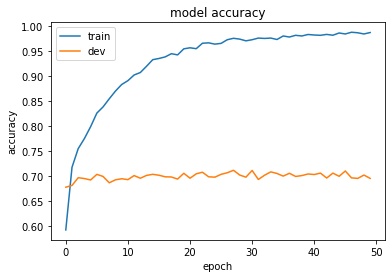

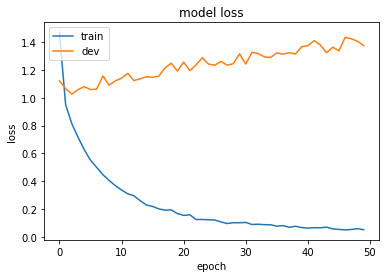

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
plt.savefig('./output/accuracyNESNetMobile.png', dpi=600)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
plt.savefig('./output/lossNESNetMobile.png', dpi=600)

In [9]:
 cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])


# custom generator
def multiple_outputs(generator, image_dir, batch_size, image_size):
    gen = generator.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False)
    
    while True:
        gnext = gen.next()
        # return image batch and 3 sets of lables
        #yield gnext[0], [np.zeros((gnext[1].shape[0], 14, 14, 1024)), gnext[1]]
        yield gnext[0], [np.zeros((gnext[1].shape[0], *cam_shape)), gnext[1]]

In [10]:
BATCH_SIZE = 12

pixels = 224
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = multiple_outputs(test_datagen, 
                                   image_dir=sf40_dir, 
                                   batch_size=BATCH_SIZE, 
                                   image_size=pixels)

valid_temp = test_datagen.flow_from_directory(sf40_dir, batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
y_true = valid_temp.classes

valid_m = len(valid_temp.classes)

mapping = dict()
for activity, idx in valid_temp.class_indices.items():
    mapping[idx] = activity


valid_steps = math.ceil(valid_m/BATCH_SIZE)

Found 9532 images belonging to 40 classes.


In [11]:
BATCH_SIZE = 12

valid_generator = test_datagen.flow_from_directory(sf40_dir, batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)

y_true = valid_generator.classes

valid_m = len(valid_generator.classes)

mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

valid_steps = math.ceil(valid_m/BATCH_SIZE)

Found 9532 images belonging to 40 classes.


In [12]:
predictions = model.predict_generator(valid_generator, valid_steps)
predictions = predictions.argmax(axis=1)
matrix = metrics.confusion_matrix(y_true, predictions)

C:\Users\Sprzetowo\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


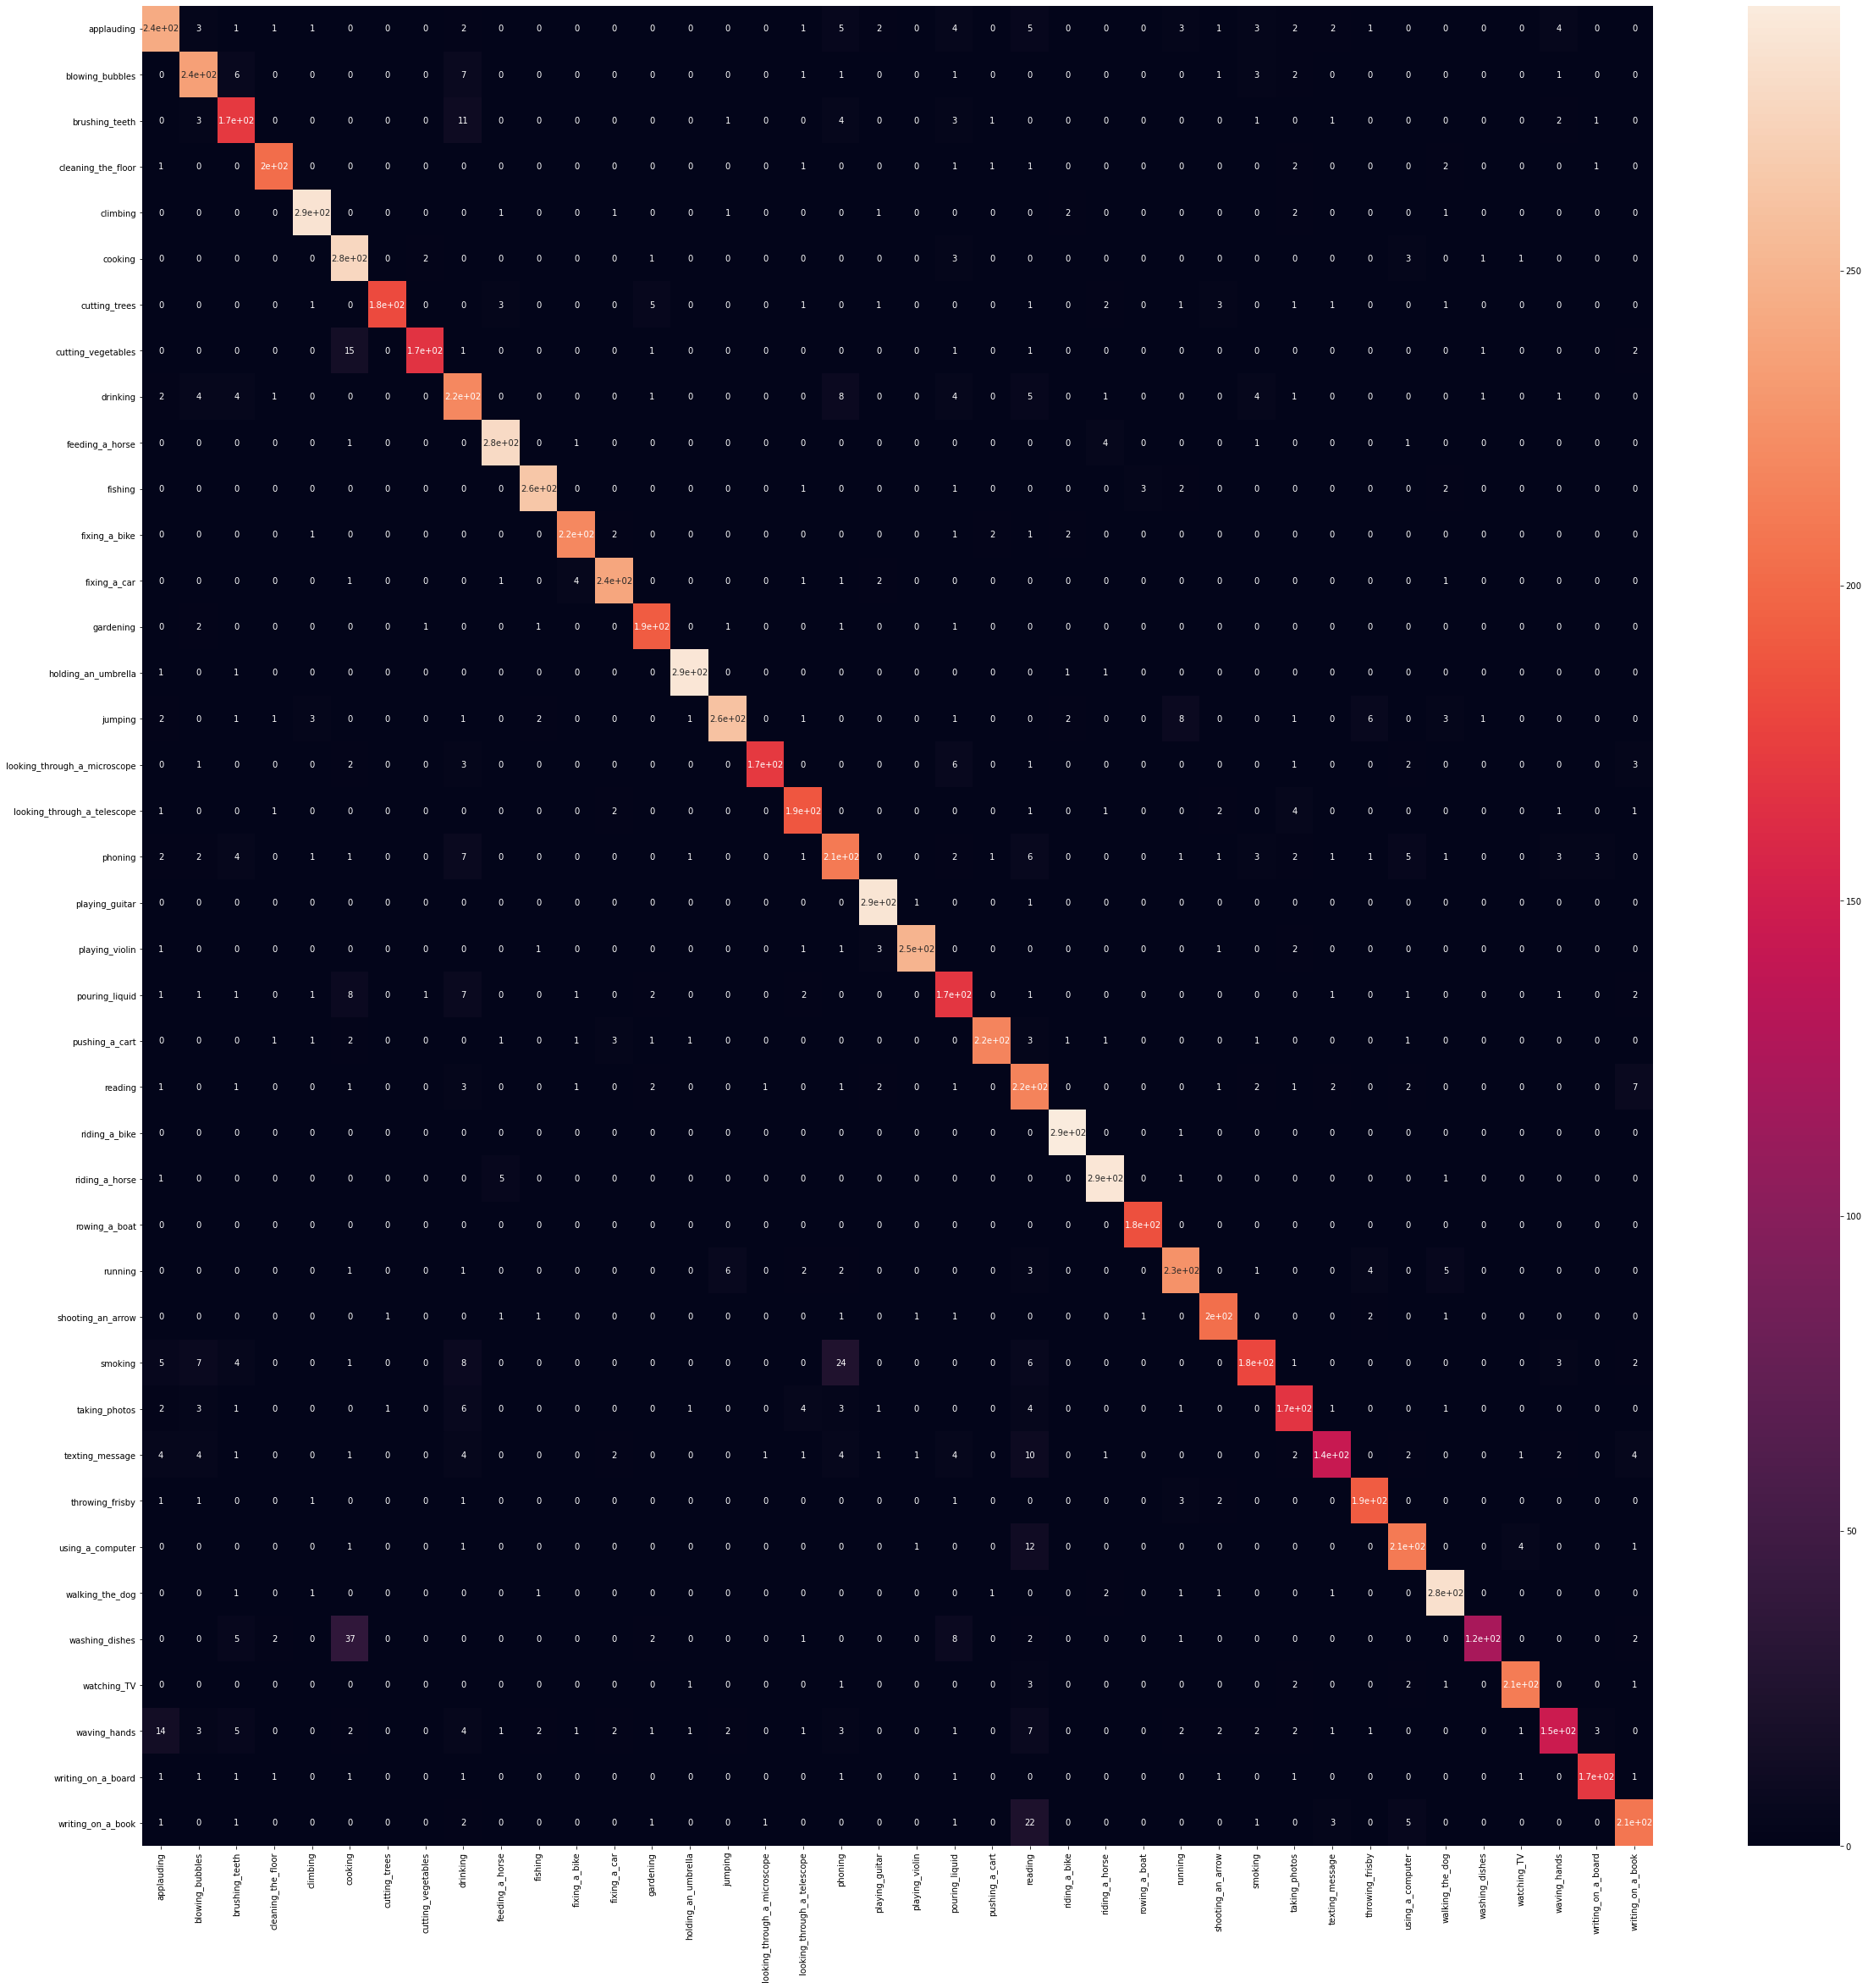

In [18]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [mapping[i] for i in range(40)], columns = [mapping[i] for i in range(40)])
plt.figure(figsize = (40, 40))

sn.heatmap(df_cm, annot=True)
plt.savefig('./output/heatmap.png')

In [24]:
def predict_image(file, model, mapping):
    
    # load an image from file
    image = load_img(file, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam, yhat = model.predict(image)
    print(cam.shape)
    print(yhat.shape)
    category = np.argmax(yhat)
    return mapping[category]

In [25]:
all_amp_layer_weights=model.layers[-1].get_weights()[0]
final_model = Model(inputs = model.input, 
                  outputs = (model.get_layer("ClassConv").output, model.get_layer("class").output))
            
final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
ClassConv (Conv2D)           (None, 7, 7, 1024)        9733120   
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
class (Dense)                (None, 40)                41000     
Total params: 14,043,836
Trainable params: 9,774,120
Non-trainable params: 4,269,716
_________________________________________________________________


In [26]:
pixels = final_model.input.get_shape().as_list()[1]
pixels

224

In [27]:
def predict(img_path, model, all_amp_layer_weights):
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(pixels,pixels))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    processed_input = preprocess_input(x)
    
    # Run model's prediction to output from last Conv Layer + category prediction
    last_conv_output, pred_vec = final_model.predict(processed_input)
    # Only 1 training example, so remove batch dimension
    last_conv_output = np.squeeze(last_conv_output)

    # Get category with highest probability
    pred = np.argmax(pred_vec)
    
    scale = pixels / last_conv_output.shape[0]
    filters = last_conv_output.shape[2]
    
    # Rescale to input image sizederstanding was it's reserved for the fi
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (scale,scale,1), order=1)
    
    # Get the weights associated with the predicted class
    amp_layer_weights = all_amp_layer_weights[:, pred]
    
    # Weighted sum of the activation maps for the predicted class.
    # Then resize back to original image size.
    final_output = np.dot(mat_for_mult.reshape((pixels*pixels, filters)), amp_layer_weights).reshape(pixels,pixels)
    
    return final_output, mapping[pred]


...

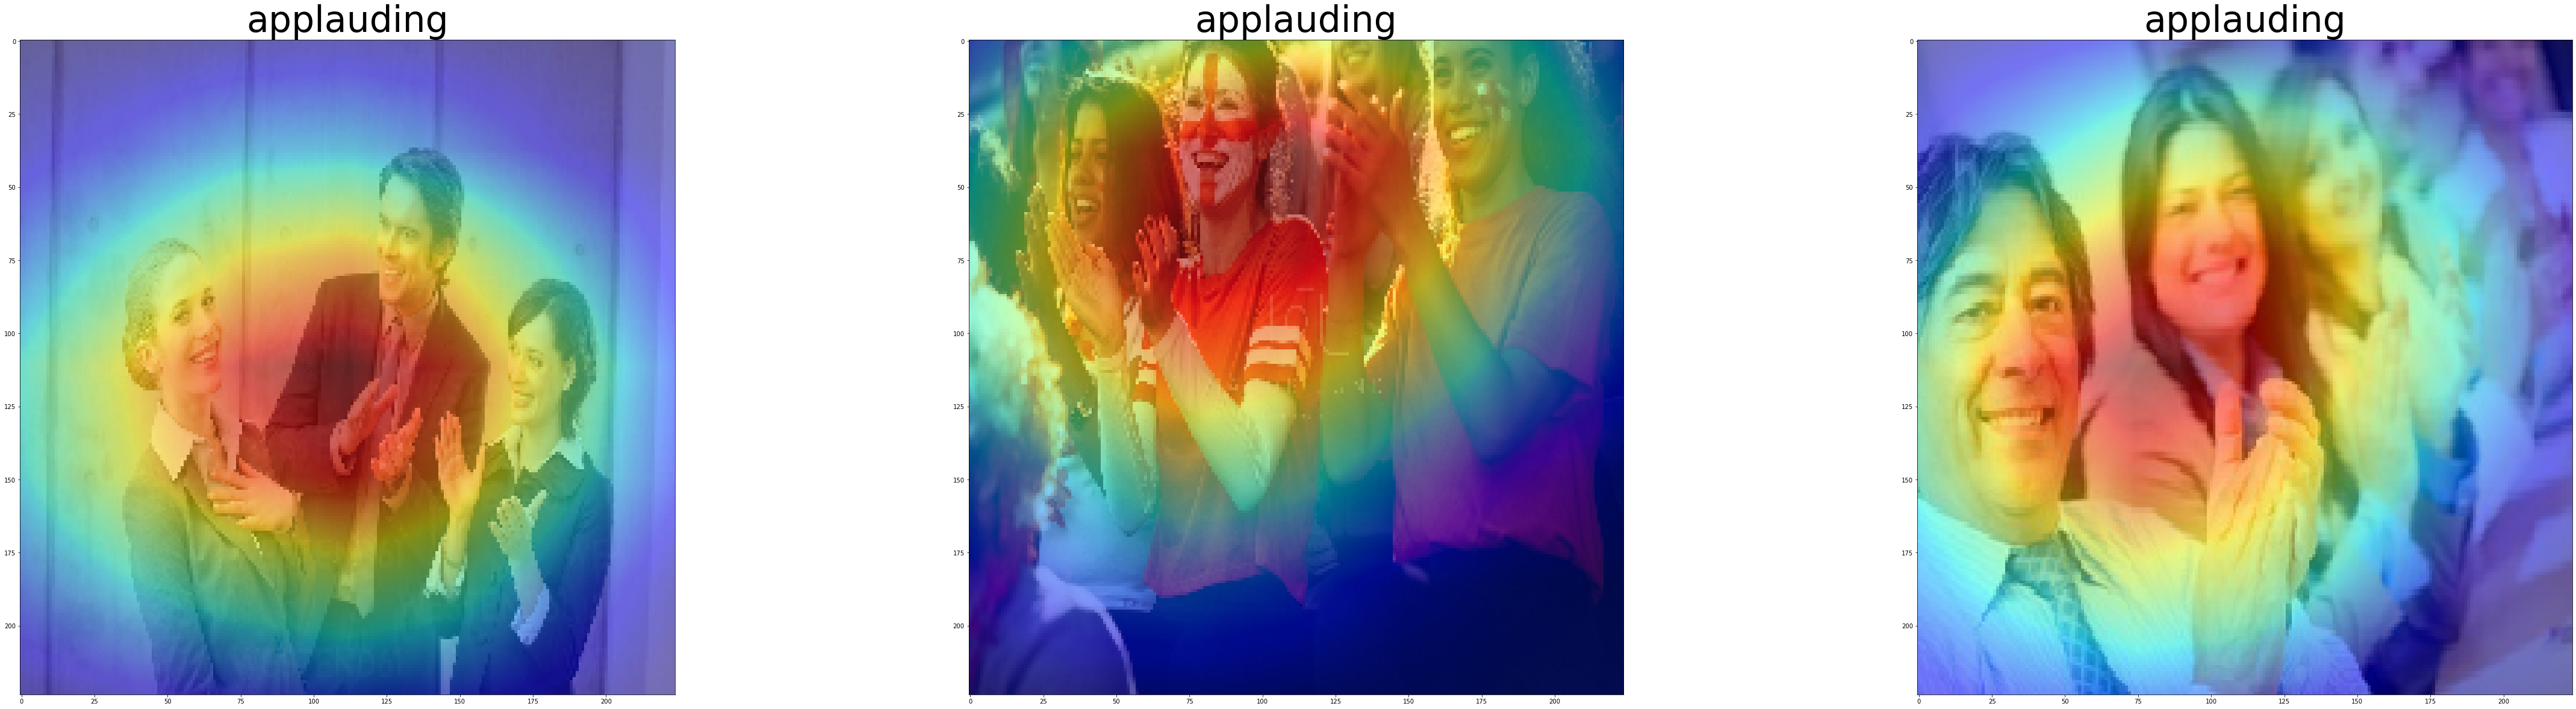

In [33]:
import matplotlib.pyplot as plt
import scipy
import glob

from tensorflow.keras.preprocessing import image

# Images downloaded from internet search engine to try out activity classification
# Images are under images/ directory 
image_dir = "pic/"
pattern  = image_dir + "*"
test_images = sorted(glob.glob(pattern))

# Details for the grid size
columns = 3
rows = math.ceil(len(test_images) / columns)
fig = plt.figure(figsize=(80, 20 * rows))

for i, image_name in enumerate(test_images):

    # Progress report
    print(".", end = '')
    image_path = image_dir + image_name
    
    ax = fig.add_subplot(rows, columns, i+1)

    # Load and display original image
    img = tf.keras.preprocessing.image.load_img(image_name, target_size=(pixels,pixels))
    plt.imshow(img)
    
    # Run forward pass to get the Class Activity Map and the predicted class
    cam, pred = predict(image_name, model, all_amp_layer_weights)
    
    # Display class activation map
    plt.imshow(cam, cmap='jet', alpha=0.5)
    
    # Set title to that of predicted class
    ax.set_title(pred, fontsize =60)
    
    
plt.show()
fig.savefig('./output/prediction.png')